# Reinforcement Learning: Continous Control
---

As you've seen, the environment for this project involves controlling a double-jointed arm, to reach target locations. 

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

![reacher](images/reacher.gif)

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1. This is a continous action space, thus we will use some actor-critic method to tackle this environment.

---

### Requirements

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!pip install -r requirements.txt

### Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from DDPG_Agent import DDPG_Agent
from utils import plot_scores
from collections import deque
from tqdm.notebook import tqdm
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DISTRIBUTED_TRAINING = True

### Choose Version (Distributed Training)

For this project, we will provide you with two separate versions of the Unity environment:

- The first version contains a single agent.
- The second version contains 20 identical agents, each with its own copy of the environment.

The second version is useful for algorithms like PPO, A3C, and D4PG that use multiple (non-interacting, parallel) copies of the same agent to distribute the task of gathering experience. Since I like a bit of a challenge I will be attempting to solve the second version where 20 agents are sharing a policy.

### Solving the Environment

**Option 1**: Solve the First Version

The task is episodic, and in order to solve the environment, your agent must get an average score of +30 over 100 consecutive episodes.

**Option 2**: Solve the Second Version

The barrier for solving the second version of the environment is slightly different, to take into account the presence of many agents. In particular, your agents must get an average score of +30 (over 100 consecutive episodes, and over all agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 20 (potentially different) scores. We then take the average of these 20 scores.
- This yields an average score for each episode (where the average is over all 20 agents).

In [2]:
if DISTRIBUTED_TRAINING == True:
    # select this option to load version 2 (with 20 agents) of the environment
    app_name = "data/Reacher_20_Agents_Windows_x86_64/Reacher_Windows_x86_64/Reacher.exe"
else:
    # select this option to load version 1 (with a single agent) of the environment
    app_name = "data/Reacher_Windows_x86_64/Reacher.exe"

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
def examine_environment(env, brain):
    print(brain)

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

### Agent: DDPG w/ Ornstien Uhlenbeck Noise

In [5]:
def follow_goal_ddpg(agent,
                    env,
                    brain_name,
                    n_agents,
                    n_episodes=1500,
                    max_t=3000,
                    print_every=10,
                    win_condition=30.0):
    
    """
    
    Continious Control using DDPG.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): how many episodes before printing scores
        n_agents (int): how many arms are in the environment
    
    """    

    scores = []
    scores_mean = []
    scores_window = deque(maxlen=100) # Score last 100 scores
    
    for i_episode in tqdm(range(1, n_episodes+1)):
        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations             # get the current state (for each agent)
        score = np.zeros(n_agents)                     # initialize the score (for each agent)
        
        for t in range(max_t):
            actions = agent.act(states)                   # consult agent for actions
            env_info = env.step(actions)[brain_name]      # take a step in the env
            next_states = env_info.vector_observations    # get next state (for each agent)
            rewards = env_info.rewards                    # get reward (for each agent)
            dones = env_info.local_done                   # see if episode finished
            
            # take a learning step
            agent.step(states, actions, rewards, next_states, dones)  
            
            score += env_info.rewards                    # update the score (for each agent)
            states = next_states                          # roll over states to next time step
            if np.any(dones):                             # exit loop if episode finished
                break

        scores.append(np.mean(score))
        scores_window.append(np.mean(score))
        scores_mean.append(np.mean(scores_window))
        
        # Print on print_every condition
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score), np.mean(scores_window)))    
        
        # Winning condition + save model parameters    
        if np.mean(scores_window) >= win_condition:
            print('\nEnvironment solved in {:d} episodes!\t Score: {:.2f} \tAverage Score: {:.2f}'.format(i_episode, np.mean(score), np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    execution_info = {'last_score': scores.pop(),
                      'solved_in': i_episode,
                      'last_100_avg': np.mean(scores_window),
                      'save_file': 'DDPG/...'}
    
    return scores, scores_mean, execution_info 

In [6]:
env = UnityEnvironment(file_name=app_name)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Info 
states = env_info.vector_observations 
state_size = states.shape[1]
action_size = brain.vector_action_space_size, 
examine_environment(env, brain)
n_agents = len(env_info.agents)

# Create the agent
ddpg = DDPG_Agent(state_size=state_size,
                  action_size=action_size[0],
                  n_agents = n_agents,
                  random_seed=42)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
  1.25147629e+00  0.00000000

### Training

Episode 10	Score: 1.29	Average Score: 0.97
Episode 20	Score: 2.89	Average Score: 1.53
Episode 30	Score: 8.34	Average Score: 2.71
Episode 40	Score: 11.30	Average Score: 4.51
Episode 50	Score: 17.09	Average Score: 6.56
Episode 60	Score: 25.20	Average Score: 8.90
Episode 70	Score: 31.75	Average Score: 11.73
Episode 80	Score: 36.39	Average Score: 14.44
Episode 90	Score: 32.93	Average Score: 16.68
Episode 100	Score: 34.30	Average Score: 18.41
Episode 110	Score: 34.34	Average Score: 21.76
Episode 120	Score: 34.94	Average Score: 24.86
Episode 130	Score: 33.58	Average Score: 27.71
Episode 140	Score: 32.74	Average Score: 30.00

Environment solved in 140 episodes!	 Score: 32.74 	Average Score: 30.00

last_score: 32.744999268092215
solved_in: 140
last_100_avg: 30.001164329421705
save_file: DDPG/...


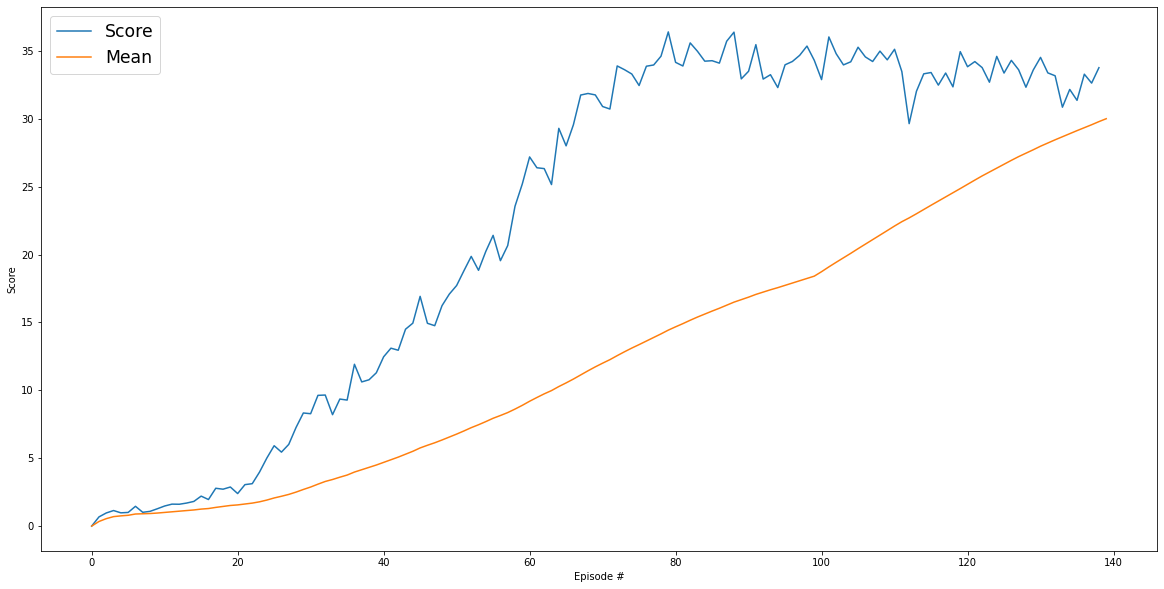

In [7]:
scores, scores_mean, execution_info =  follow_goal_ddpg(ddpg,
                                                        env,
                                                        brain_name,
                                                        n_agents)

# Close environment
env.close()

# print stats
plot_scores(scores, scores_mean, execution_info)

# Testing Framework

Load in the custom saved parameters and view the agent behave.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from DDPG_Agent import DDPG_Agent
from collections import deque
import torch

DISTRIBUTED_TRAINING = True
if DISTRIBUTED_TRAINING == True:
    # select this option to load version 2 (with 20 agents) of the environment
    app_name = "data/Reacher_20_Agents_Windows_x86_64/Reacher_Windows_x86_64/Reacher.exe"
else:
    # select this option to load version 1 (with a single agent) of the environment
    app_name = "data/Reacher_Windows_x86_64/Reacher.exe"

In [ ]:
# Load Parameter of choice
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# Load Unity Environment
env = UnityEnvironment(file_name=app_name)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations             # get the current state (for each agent)

state_size = states.shape[1]
action_size = brain.vector_action_space_size, 
n_agents = len(env_info.agents)

ddpg_test = DDPG_Agent(state_size=state_size,
                  action_size=action_size[0],
                  n_agents=n_agents,
                  random_seed=42)

checkpoint_1 = torch.load('checkpoint_actor.pth', map_location=map_location)
checkpoint_2 = torch.load('checkpoint_critic.pth', map_location=map_location)
ddpg_test.actor_local.load_state_dict(checkpoint_1)
ddpg_test.critic_local.load_state_dict(checkpoint_2)


score = np.zeros(n_agents)                     # initialize the score (for each agent)

while True:
    actions = ddpg_test.act(states)               # consult agent for actions
    env_info = env.step(actions)[brain_name]      # take a step in the env
    next_states = env_info.vector_observations    # get next state (for each agent)
    rewards = env_info.rewards                    # get reward (for each agent)
    dones = env_info.local_done                   # see if episode finished
    score += rewards                              # update the score
    states = next_states                            # roll over the state to next time step
    print('\rScore: {:.2f}'.format(np.mean(score)), end='')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 16.60